# Wavelength-dependent Effective Index
> Sometimes it's useful to have a wavelength-dependent effective index model.

In [1]:
import json
import os
from functools import cache

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meow as mw
import numpy as np
import pandas as pd
import sax
from sklearn.preprocessing import PolynomialFeatures
from tqdm.notebook import tqdm

## Waveguide Modes

> NOTE: this example shows a simple 1D linear interpolated neff model vs wavelength. To see an example of a grid interpolation over wavelength and width, see the 'Layout Aware' example.

We can use [meow](https://github.com/flaport/meow) to calculate the modes in our waveguide.

In [2]:
def find_waveguide_modes(
    wl: float = 1.55,
    n_box: float = 1.4,
    n_clad: float = 1.4,
    n_core: float = 3.4,
    t_slab: float = 0.1,
    t_soi: float = 0.22,
    w_core: float = 0.45,
    du=0.02,
    n_modes: int = 10,
    cache_path: str = "modes",
    replace_cached: bool = False,
):
    length = 10.0
    delta = 10 * du
    env = mw.Environment(wl=wl)
    cache_path = os.path.abspath(cache_path)
    os.makedirs(cache_path, exist_ok=True)
    fn = f"{wl=:.2f}-{n_box=:.2f}-{n_clad=:.2f}-{n_core=:.2f}-{t_slab=:.3f}-{t_soi=:.3f}-{w_core=:.3f}-{du=:.3f}-{n_modes=}.json"
    path = os.path.join(cache_path, fn)
    if not replace_cached and os.path.exists(path):
        return [mw.Mode.model_validate(mode) for mode in json.load(open(path, "r"))]

    # fmt: off
    m_core = mw.SampledMaterial(name="slab", n=np.asarray([n_core, n_core]), params={"wl": np.asarray([1.0, 2.0])}, meta={"color": (0.9, 0, 0, 0.9)})
    m_clad = mw.SampledMaterial(name="clad", n=np.asarray([n_clad, n_clad]), params={"wl": np.asarray([1.0, 2.0])}) 
    m_box = mw.SampledMaterial(name="box", n=np.asarray([n_box, n_box]), params={"wl": np.asarray([1.0, 2.0])})
    box = mw.Structure(material=m_box, geometry=mw.Box(x_min=- 2 * w_core - delta, x_max= 2 * w_core + delta, y_min=- 2 * t_soi - delta, y_max=0.0, z_min=0.0, z_max=length))
    slab = mw.Structure(material=m_core, geometry=mw.Box(x_min=-2 * w_core - delta, x_max=2 * w_core + delta, y_min=0.0, y_max=t_slab, z_min=0.0, z_max=length))
    clad = mw.Structure(material=m_clad, geometry=mw.Box(x_min=-2 * w_core - delta, x_max=2 * w_core + delta, y_min=0, y_max=3 * t_soi + delta, z_min=0.0, z_max=length))
    core = mw.Structure(material=m_core, geometry=mw.Box(x_min=-w_core / 2, x_max=w_core / 2, y_min=0.0, y_max=t_soi, z_min=0.0, z_max=length))
    
    cell = mw.Cell(structures=[box, clad, slab, core], mesh=mw.Mesh2D( x=np.arange(-2*w_core, 2*w_core, du), y=np.arange(-2*t_soi, 3*t_soi, du), ), z_min=0.0, z_max=10.0)
    cross_section = mw.CrossSection.from_cell(cell=cell, env=env)
    modes = mw.compute_modes(cross_section, num_modes=n_modes)
    # fmt: on

    json.dump([json.loads(mode.model_dump_json()) for mode in modes], open(path, "w"))

    return modes

We can also create a rudimentary model for the silicon refractive index:

In [3]:
def silicon_index(wl):
    """a rudimentary silicon refractive index model"""
    a, b = 0.2411478522088102, 3.3229394315868976
    return a / wl + b

We can now easily calculate the modes of a strip waveguide:

In [4]:
modes = find_waveguide_modes(wl=1.5, n_core=silicon_index(wl=1.5))

The fundamental mode is the mode with index 0:

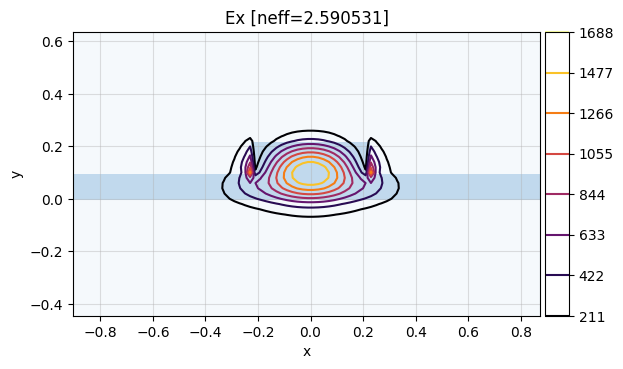

In [5]:
mw.visualize(modes[0])

## Interpolated Effective Index Model

```{note}
An interpolated effective index model is the easiest way to convert simulation data to a SAX model. However please never interpolated noisy data (e.g. from measurements). To handle noisy data see [Effective Index Model Fitting](#effective-index-model-fitting).
```

In [6]:
wavelengths = np.linspace(1.0, 2.0, 11)
neffs = np.zeros_like(wavelengths)
for i, wl in enumerate(tqdm(wavelengths)):
    modes = find_waveguide_modes(
        wl=wl, n_core=silicon_index(wl), w_core=0.5, replace_cached=False
    )
    neffs[i] = np.real(modes[0].neff)

  0%|          | 0/11 [00:00<?, ?it/s]

This results in the following effective indices:

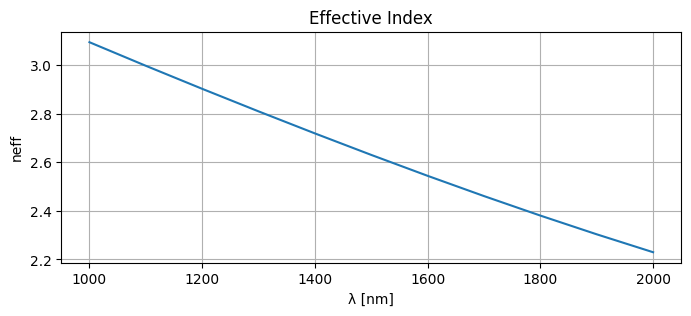

In [7]:
plt.figure(figsize=(8, 3))
plt.plot(wavelengths * 1000, neffs)
plt.ylabel("neff")
plt.xlabel("λ [nm]")
plt.title("Effective Index")
plt.grid(True)
plt.show()

We can store the data in a csv:

In [8]:
df = pd.DataFrame({"wl": wavelengths, "neff": neffs})
df.to_csv("neff_data.csv", index=False)

First, define a cached data loader:

In [9]:
@cache
def load_neff_data():
    df = pd.read_csv("neff_data.csv")
    wls = jnp.asarray(df["wl"].values)  # convert to JAX array
    neffs = jnp.asarray(df["neff"].values)  # convert to JAX array
    return wls, neffs

We can do a simple interpolation on the effective index:

In [10]:
def interp_neff(wl=1.5):
    # usually we put data loading in a block like this
    # to tell JAX this part of the code should not be traced while jitting:
    with jax.ensure_compile_time_eval():
        wls, neffs = load_neff_data()

    # next make sure 'wl' is an array
    wl = jnp.asarray(wl)

    # now, interpolate
    # return jnp.interp(wl, wls, neffs)

    # it's actually slightly better to interpolate effective
    # indices in the frequency domain because neff is more
    # linear in that representation:
    return jnp.interp(
        1 / wl, 1 / wls[::-1], neffs[::-1]
    )  # jnp.interp expects neffs to be sorted low to high. We're inverting the direction when taking the inverse:

```{note}
If you want something fancier than linear interpolation, check out [interpax](https://github.com/f0uriest/interpax), which allows for cubic interpolation in jax on 1D (e.g. wl), 2D (e.g. wl and width) and 3D (e.g. wl, width and temperature) data.
```

In [11]:
print(interp_neff(1.6452))
print(interp_neff([1.641, 1.79432]))
print(interp_neff([[1.61324, 1.7987], [1.8087, 1.9234]]))

2.5049856442360503
[2.50850865 2.38468891]


[[2.53225532 2.38135659]
 [2.3733323  2.28543688]]


That's it! You can now create a waveguide model as follows:

In [12]:
def straight(
    *,
    wl=1.55,
    length: float = 10.0,
    loss: float = 0.0,
):
    """A simple straight waveguide model.

    Args:
        wl: wavelength in microns.
        length: length of the waveguide in microns.
        loss: loss in dB/cm.
    """
    neff = interp_neff(wl)
    phase = 2 * jnp.pi * neff * length / wl
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )

In [13]:
straight()

{('in0', 'out0'): Array(-0.42264116-0.90629711j, dtype=complex128),
 ('out0', 'in0'): Array(-0.42264116-0.90629711j, dtype=complex128)}

```{note}
Note that we don't need the group index for this model! All the group index info is actually already available in the effective index model through `ng = neff - λ dneff/dλ`.
```

## Effective Index Model Fitting

interpolating is a good choice when using 'clean' simulation data. However, when using noisy measurement data we might need something else.

Let's create a fake 'noisy measurement' by adding noise to our interpolated model:

In [14]:
def measure_neff(wls, std=0.01, random_state=np.random):
    wls = jnp.array(wls)
    return interp_neff(wls) * (1 + std * random_state.randn(*wls.shape))

We can do 20 measurements for example:

In [15]:
random_state = np.random.RandomState(seed=42)
measured_neff = np.stack(
    [measure_neff(wavelengths, random_state=random_state) for _ in range(20)], 0
)

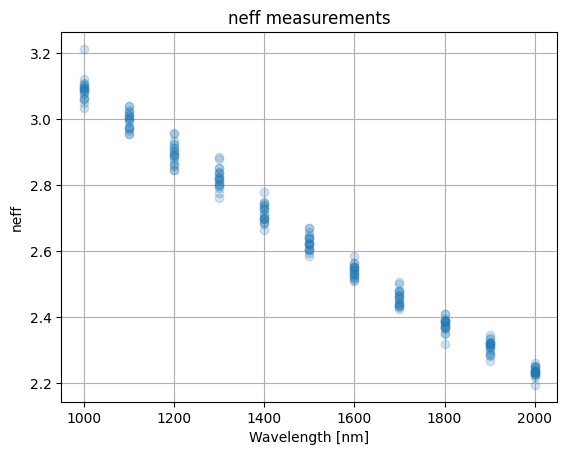

In [16]:
plt.plot(
    1000 * wavelengths, measured_neff.T, marker="o", ls="none", color="C0", alpha=0.2
)
plt.grid(True)
plt.xlabel("Wavelength [nm]")
plt.ylabel("neff")
plt.title("neff measurements")
plt.show()

In [17]:
poly = PolynomialFeatures(degree=2, include_bias=True)
poly.fit(measured_neff, wavelengths)
poly.transform(measured_neff)

array([[1.        , 3.10872665, 2.99229414, ..., 5.36318207, 5.13974782,
        4.925622  ],
       [1.        , 3.07895478, 3.00368739, ..., 5.46211369, 5.19931992,
        4.94916971],
       [1.        , 3.09545038, 2.95374546, ..., 5.50381918, 5.23023584,
        4.97025176],
       ...,
       [1.        , 3.09110863, 2.9710635 , ..., 5.21208448, 5.09824434,
        4.98689065],
       [1.        , 3.09516209, 2.96218875, ..., 5.36011275, 5.18878722,
        5.02293776],
       [1.        , 3.2125404 , 3.01354351, ..., 5.25407883, 5.11506948,
        4.97973796]], shape=(20, 78))

In [18]:
coeffs = np.polyfit(
    x=np.stack([wavelengths for _ in measured_neff]).ravel(),
    y=measured_neff.ravel(),
    deg=2,
)
print(coeffs)

[ 0.14164498 -1.28752935  4.24077288]


In [19]:
def fitted_neff(wl=1.5):
    # always make sure its an array:
    wl = jnp.asarray(wl)

    # it's fine to hardoce a few coefficients:
    coeffs = jnp.asarray([0.14164498, -1.28752935, 4.24077288])

    return coeffs[-1] + coeffs[-2] * wl + coeffs[-3] * wl**2

Let's plot the fitted model:

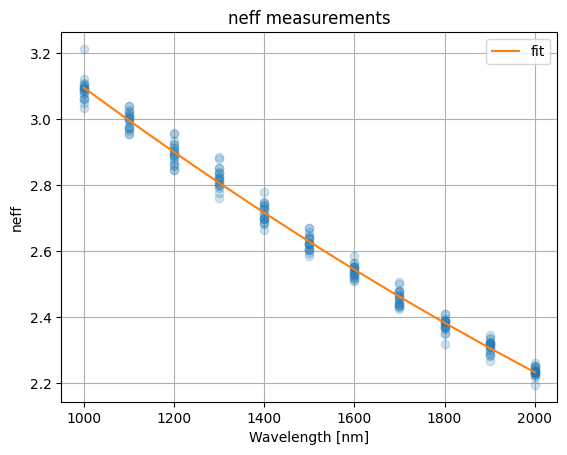

In [20]:
plt.plot(
    1000 * wavelengths, measured_neff.T, marker="o", ls="none", color="C0", alpha=0.2
)
plt.plot(1000 * wavelengths, fitted_neff(wavelengths), color="C1", label="fit")
plt.legend()
plt.grid(True)
plt.xlabel("Wavelength [nm]")
plt.ylabel("neff")
plt.title("neff measurements")
plt.show()

```{note}
In fact it's probably better to fit in the frequency domain, since then you could probably fit with just a straight line or a quadratic with a very low quadratic coefficient. I leave this as an exercise to the reader 🙂
```

This is now our final straight model:

In [21]:
def straight(
    *,
    wl=1.55,
    length: float = 10.0,
    loss: float = 0.0,
):
    """A simple straight waveguide model.

    Args:
        wl: wavelength in microns.
        length: length of the waveguide in microns.
        loss: loss in dB/cm.
    """
    neff = fitted_neff(wl)
    phase = 2 * jnp.pi * neff * length / wl
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )

In [22]:
straight()

{('in0', 'out0'): Array(-0.42561599-0.90490388j, dtype=complex128),
 ('out0', 'in0'): Array(-0.42561599-0.90490388j, dtype=complex128)}